In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
#Importing all the neccessary libraries
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import math
from sklearn.decomposition import TruncatedSVD

<b> The immediate code block below does the following things :</b>
<br>
<ol>
    <li>Load the Amazon dataset.</li>

<li>Classify the reviews initially based on their score rating and give them a 'Positve' or a 'Negative' tag.</li>
<li>Remove duplicate/redundant datas.</li>
<li>Get an idea of how much percentage data were actually duplicates.</li>
<li>Plot a histogram which will display the distribution of the number of positive and negative reviews after de-duplication.</li>
</ol>

In [3]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('/kaggle/input/amazon-fine-food-reviews/database.sqlite') 

#Filter only positive and negative reviews. Do nbot consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

#Removing duplicate entries based on past knowledge.
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64

The shape of the data matrix after deduplication : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


<b>In this code block :</b><br>
<ol>
<li>I am creating a copy of the final_data dataset called 'sampled_dataset' by dropping the unwanted columns that we don't need for this problem.</li>
<li>Sorting the data according to time, such that the oldest reviews are displayed at the top and the latest reviews are displayed at the bottom.</li>
<li>Displaying information about the number of postive and negative reviews in the sampled dataset, using a Histogram.</li>
    </ol>

The shape of the sampled dataset after dropping unwanted columns :  (364171, 4)

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0
1,1351209600,Very pleased with the quality of the espresso....,Positive,1
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1
7,1351209600,try it & we shared with the familys/all han th...,Positive,1
8,1351209600,If you like butter flavor this is the best mic...,Positive,1
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1


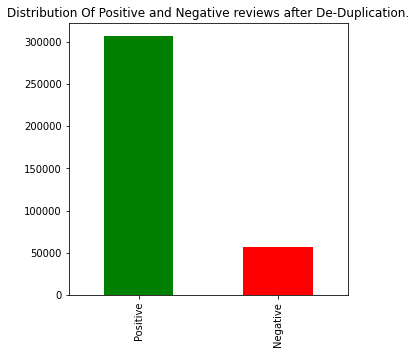

In [4]:
'''Creating a sampled dataset dropping the unwanted columns that we don't need for this problem, from the actual dataset.'''
#Creating a subset of the "final_data" table with randomly selecting 360000 samples
#sampled_dataset = final_data.sample(n=360000, replace=False, random_state=0).reset_index()
#print("\nThe shape of the sampled dataset : ", sampled_dataset.shape)

#Dropping unwanted columns for now.
sampled_dataset=final_data.drop(labels=['Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary'], axis=1)
print("The shape of the sampled dataset after dropping unwanted columns : ", sampled_dataset.shape)

#Sorting data according to Time in ascending order => Time Based Splitting Step 1.
sampled_dataset=sampled_dataset.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sampled_dataset = sampled_dataset.reset_index()
sampled_dataset=sampled_dataset.drop(labels=['index'], axis=1)

#Display distribution of Postive and Negative reviews in a bar graph
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))
sampled_dataset.head(5)

#Display the first 10 rows of the sampled_dataset (All the reviews are arranged according to time)
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

<b>In this code block :</b><br>
<ol>
<li>We define two functions which will remove the HTML tags and punctuations from each review.</li>
<li>At the end of this code block, each review will contain texts which will only contain alphabetical strings.</li>
<li>We will apply techniques such as stemming and stopwords removal.</li>
<li>We will create two columns in the sampled dataset - 'CleanedText' and 'RemovedHTML'.</li>
<li>'CleanedText' column will basically contain the data corpus after stemming the each reviews and removing stopwords from each review. We will use this for our Bag of Word model.</li>
<li>'RemovedHTML' column will contain the data corpus from which only the HTML tags and punctuations are removed. We will use this column for our TF-IDF model, Average Word2Vec model and TF-IDF weighted average Word2Vec model.</li>
<li>Store the final table in a dataset called 'sampled_dataset' for future use.</li>
</ol>

In [5]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

from tqdm import tqdm

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc.
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return cleaned_text

#Stemming and stopwords removal
import re
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

#Building a data corpus by removing all stopwords except 'not'. Because 'not' can be an important estimator to differentiate between positive and negative reviews.    
count=0                   #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
data_corpus=[]
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
stemed_word=''
for review in tqdm(sampled_dataset['Text'].values):
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): #Checking if a word consists of only alphabets + word length is greater than 2.    
                if(cleaned_words.lower() not in custom_stopwords):
                    stemed_word=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(stemed_word)
                    if (sampled_dataset['SentimentPolarity'].values)[count] == 'Positive': 
                        all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
                    if(sampled_dataset['SentimentPolarity'].values)[count] == 'Negative':
                        all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
                else:
                    continue
            else:
                continue 
    string = " ".join(filtered_sentence) #Final string of cleaned words    
    data_corpus.append(string) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
    
print("The length of the data corpus is : {}".format(len(data_corpus)))

#Building a data corpus by removing only the Punctuations and HTML tags. Stopwords are preserved. Words are not stemmed. This is useful for Average Word2Vec, TF-IDF W2V.
string=' '    
not_stemmed_corpus=[]
for review in tqdm(sampled_dataset['Text'].values):
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if(cleaned_words.isalpha()): #Checking if a word consists of only alphabets    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    string = " ".join(filtered_sentence)    
    not_stemmed_corpus.append(string) 
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
sampled_dataset['CleanedText']=data_corpus 

#Adding a column of PreserveStopwords to the table final which stores the data corpus in which stopwords are preserved and words are not stemmed.  
sampled_dataset['PreserveStopwords']=not_stemmed_corpus 

print("Printing the number of positive and negative reviews after data cleaning.")
print(sampled_dataset['SentimentPolarity'].value_counts())

"""#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)
"""

  0%|          | 617/364171 [00:00<00:59, 6108.78it/s]

The length of the data corpus is : 364171


100%|██████████| 364171/364171 [01:14<00:00, 4884.19it/s]


Printing the number of positive and negative reviews after data cleaning.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64


'#Store final table into an SQlLite table for future.\nconnection_sqlobject = sqlite3.connect(\'sampled_dataset_all_reviews.sqlite\')\nc=connection_sqlobject.cursor()\nconnection_sqlobject.text_factory = str\nsampled_dataset.to_sql(\'Reviews\', connection_sqlobject, schema=None, if_exists=\'replace\', index=True, index_label=None, chunksize=None, dtype=None)\n\n#Display the first 10 rows of the sampled_dataset.\nprint("\nFirst 10 rows of the sampled_dataset.")\nsampled_dataset.head(10)\n'

In [6]:
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)


First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels,CleanedText,PreserveStopwords
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0,got coffe day ago coffe bean yesterday today m...,i just got this coffee a few days ago i had co...
1,1351209600,Very pleased with the quality of the espresso....,Positive,1,pleas qualiti espresso pod sturdi enough withs...,very pleased with the quality of the espresso ...
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1,bought new oster belgium waffl maker best waff...,bought this with my new oster belgium waffle m...
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0,drink lot tea world far worst tast tea purchas...,we drink a lot of tea from all over the world ...
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1,alway bought pure vanilla extract mexico got t...,i have always bought my pure vanilla extract i...
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1,label cadburi screme egg allergi inform manufa...,from the label on the cadbury screme egg aller...
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1,best soup mix tri love make soup best tast eas...,best soup mix i ve tried i love making soup an...
7,1351209600,try it & we shared with the familys/all han th...,Positive,1,tri share famili han thumb cut good lite oliv ...,try it we shared with the familys all han thum...
8,1351209600,If you like butter flavor this is the best mic...,Positive,1,like butter flavor best microwav popcorn avail...,if you like butter flavor this is the best mic...
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1,love sort tea friend know travel often bring t...,i love all sorts of teas my friends know this ...


<b>In this code block :</b><br>
<ol>
   <li> We define a function which is used to perform column standardization on any give input matrix.</li>
<li>We define a function which is used to get the top 50 features from both the negative and the positive review classes.</li>
<li>We define a function which is used to measure the various performance metrics for a given model. We will use accuracy as a metric to evaluate this models performance on unseen data.</li>
<li>We define a function which is used to obtain the optima value of alpha along with the best mnodel estimator, using time series cross validation along with grid search CV.</li>
<li>We define a function which is used to plot and visually represent the errors vs hyperparameter plot.</li>
<li>We fit the naive base classifier to our training data and make the final model.</li>
</ol>

In [30]:
#Sample the data 5000 records
X = sampled_dataset['CleanedText'][0:5000]
Y = sampled_dataset['Class_Labels'][0:5000]
#Split the dataset to train and test
split = int(0.8*X.shape[0])
X_train = X[0:split]; X_test = X[split:];
Y_train = Y[0:split]; Y_test = Y[split:];

In [32]:
#Creating the BOW for cleaned text
count_vectoriser = CountVectorizer().fit(X_train)
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = count_vectoriser.transform(X_train)
X_test_vectors = count_vectoriser.transform(X_test)

def standardize(X_train_vectors, X_test_vectors):
#Standardise the data
    from sklearn.preprocessing import StandardScaler
    standard_scalar = StandardScaler(with_mean=False).fit(X_train_vectors)
    X_train_vectors = standard_scalar.transform(X_train_vectors)
    X_test_vectors = standard_scalar.transform(X_test_vectors)
    print("The shape of trained vectors is: {}".format(X_train_vectors.shape))
    print("The shape of test vectors is: {}".format(X_test_vectors.shape))
    return (X_train_vectors, X_test_vectors)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)


Creating the BOW vectors using the cleaned corpus
The shape of trained vectors is: (4000, 7960)
The shape of test vectors is: (1000, 7960)


In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

def get_GridSearchCV_estimator(vectorizationType, X_train, Y_train, X_test, Y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    from sklearn.model_selection import TimeSeriesSplit
    alphas = np.logspace(-5, 4, 100)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 10
    model = MultinomialNB()
    my_cv = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=my_cv, scoring='f1', n_jobs=6)
    gsearch_cv.fit(X_train, Y_train)
    print("\nGridSearchCV completed for {} model!".format(vectorizationType))
    print("Best estimator for {} model : ".format(vectorizationType), gsearch_cv.best_estimator_)
    print("Best Score for {} model : ".format(vectorizationType), gsearch_cv.best_score_)
    return gsearch_cv


#Perform 10-fold cross validation on the train set
print("Starting Cross Validation steps...")
gsearch_cv = get_GridSearchCV_estimator("Bag-of-Words", X_train_vectors, Y_train, X_test_vectors, Y_test)

Starting Cross Validation steps...

GridSearchCV completed for Bag-of-Words model!
Best estimator for Bag-of-Words model :  MultinomialNB(alpha=10000.0)
Best Score for Bag-of-Words model :  0.9157884957370314


The optimal value of alpha is : 10000.0


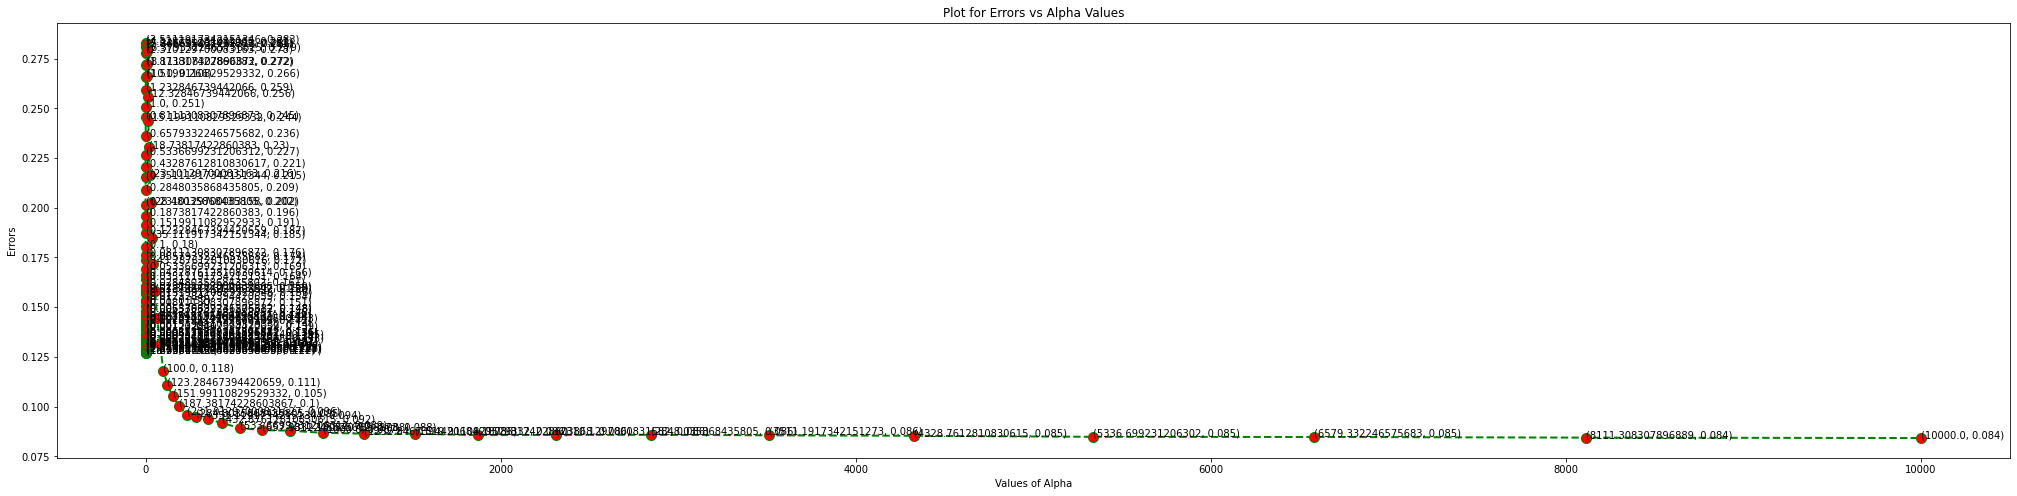

In [28]:
def plot_errors(gsearch_cv):
    '''This function is used to plot the curve for mean squared errors vs alpha values'''
    #Get cross validation scores. Here we obtain the alpha values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    mts = cv_result["mean_test_score"]        #list that will hold the mean of cross validation accuracy scores for each alpha
    alphas = cv_result["params"]

    alpha_values = []                         #list that will hold all the alpha values that the grid search cross validator tried.
    for i in range(0,len(alphas)):
        alpha_values.append(alphas[i]["alpha"])

    #Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    mse = [1 - x for x in mts]

    #Determining best alpha from errors. 'alpha' will be best for the lowest value for error
    optimal_alpha = alpha_values[mse.index(min(mse))] #Laplace smoothing
    print('The optimal value of alpha is : {}'.format(optimal_alpha))     

    #Plot error vs alpha values
    plt.figure(figsize=(35,8))
    plt.plot(alpha_values , mse, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    for xy in zip(alpha_values, np.round(mse,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('Plot for Errors vs Alpha Values')
    plt.xlabel('Values of Alpha')
    plt.ylabel('Errors')
    plt.show()
    
    return (optimal_alpha,mse)

#Plot the graphical representation of the mean squared error vs the alpha values obtained during cross validation.
optimal_alpha, mse = plot_errors(gsearch_cv)

In [12]:
#Initialize the Naive Bayes constructor using alpha = optimal_alpha
nb_classifier = gsearch_cv.best_estimator_

#Fit the model to the train set using optimal alpha
nb_classifier.fit(X_train_vectors, Y_train)

MultinomialNB(alpha=10000.0)

In [42]:
def top_features(nb_classifier, vectorizer_object):
    '''Get top 50 features displayed from both the negative and the positive review classes.'''
    neg_class_prob_sorted = (-nb_classifier.feature_log_prob_[0, :]).argsort() #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    pos_class_prob_sorted = (-nb_classifier.feature_log_prob_[1, :]).argsort()
    neg_class_features = np.take(vectorizer_object.get_feature_names(), neg_class_prob_sorted[:50])
    pos_class_features = np.take(vectorizer_object.get_feature_names(), pos_class_prob_sorted[:50])
    print("The top 50 most frequent words from the positive class are :\n")
    print(pos_class_features)
    print("\nThe top 50 most frequent words from the negative class are :\n")
    print(neg_class_features)
    del(neg_class_prob_sorted, pos_class_prob_sorted, neg_class_features, pos_class_features)

#Display the top features of both the negative and positive reviews
top_features(nb_classifier, count_vectoriser)

The top 50 most frequent words from the positive class are :

['great' 'love' 'good' 'like' 'tast' 'not' 'use' 'tri' 'flavor' 'one'
 'product' 'make' 'get' 'best' 'time' 'would' 'buy' 'also' 'find' 'realli'
 'price' 'much' 'well' 'littl' 'store' 'recommend' 'coffe' 'perfect'
 'better' 'delici' 'order' 'year' 'found' 'eat' 'work' 'enjoy' 'favorit'
 'need' 'day' 'way' 'even' 'look' 'high' 'amazon' 'give' 'nice' 'want'
 'bought' 'purchas' 'first']

The top 50 most frequent words from the negative class are :

['not' 'disappoint' 'tast' 'product' 'like' 'wast' 'would' 'buy' 'money'
 'return' 'one' 'order' 'away' 'bad' 'receiv' 'thought' 'stale' 'aw'
 'threw' 'review' 'tri' 'box' 'packag' 'could' 'look' 'even' 'howev'
 'mayb' 'want' 'realli' 'bought' 'amazon' 'open' 'pictur' 'throw'
 'purchas' 'trash' 'much' 'brand' 'know' 'item' 'sorri' 'get' 'flavor'
 'good' 'refund' 'price' 'stuck' 'never' 'terribl']



'''PERFORMANCE EVALUATION'''


Detailed report for the Bag-of-Words Vectorization.

The number of accurate predictions out of 1000 data points on unseen data is 866
Accuracy of the Bag-of-Words model on unseen data is 86.6 %
Precision of the Bag-of-Words model on unseen data is 0.866
Recall of the Bag-of-Words model on unseen data is 1.0
F1 score of the Bag-of-Words model on unseen data is 0.9282

Clasification report for Bag-of-Words model : 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.87      1.00      0.93       866

    accuracy                           0.87      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.75      0.87      0.80      1000


The True Positives Rate is : 1.0
The True Negatives Rate is : 0.0
The False Positives Rate is : 1.0
The False Negatives Rate is : 0.0

Of all the reviews that the model has predicted to be positive, 86.6% of them are actua

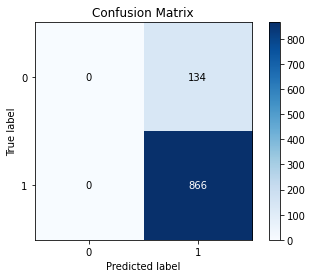

In [43]:
def performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse): #MSE : Mean Squared Loss
    '''Function to measure the various performance metrics for a given model.'''
    print("\n'''PERFORMANCE EVALUATION'''")
    print("\n\nDetailed report for the {} Vectorization.".format(vectorizationType))

    #Predict the labels for the test set.
    y_pred = nb_classifier.predict(X_test)
    
    #Evaluate the accuracy of the model on test set
    test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
    points = accuracy_score(y_test, y_pred, normalize=False)
    print('\nThe number of accurate predictions out of {} data points on unseen data is {}'.format(X_test.shape[0], points))
    print('Accuracy of the {} model on unseen data is {} %'.format(vectorizationType, np.round(test_accuracy,2)))
    
    #Get the precision, recall and F1 score for this model.
    print("Precision of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.precision_score(y_test ,y_pred),4)))
    print("Recall of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.recall_score(y_test ,y_pred),4)))
    print("F1 score of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.f1_score(y_test ,y_pred),4)))
    
    #Classification Report
    print ('\nClasification report for {} model : \n'.format(vectorizationType))
    print(metrics.classification_report(y_test,y_pred))
    
    #Print the Conclusions on the trained dataset
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp+fn #p = total number of actual postives
    n = fp+tn #p = total number of actual negatives
    TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
    print("\nThe True Positives Rate is : {}".format(TPR))
    print("The True Negatives Rate is : {}".format(TNR))
    print("The False Positives Rate is : {}".format(FPR))
    print("The False Negatives Rate is : {}".format(FNR))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))
      
    #Save the below list for later use to display model information
    info_model_NB = [vectorizationType, optimal_alpha, np.round(np.array(mse).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4), points]
    with open('info_model_NB.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_NB)
        filehandle.writelines("\n")
        
    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix for {} model.".format(vectorizationType))
    sciplot.plot_confusion_matrix(y_test ,y_pred)
    
    #Free memory allocations
    del(X_train, y_train, X_test, y_test, vectorizationType, y_pred, nb_classifier)


performance(nb_classifier, "Bag-of-Words", X_train_vectors, Y_train, X_test_vectors, Y_test, optimal_alpha, mse)


In [47]:
def standardize(X_train_vectors, X_test_vectors):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=False)
    scalar.fit(X_train_vectors)
    X_train_vectors = scalar.transform(X_train_vectors)
    X_test_vectors = scalar.transform(X_test_vectors)
    print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
    print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))
    return (X_train_vectors, X_test_vectors)

def top_features(nb_classifier, vectorizer_object):
    '''Get top 50 features displayed from both the negative and the positive review classes.'''
    neg_class_prob_sorted = (-nb_classifier.feature_log_prob_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    pos_class_prob_sorted = (-nb_classifier.feature_log_prob_[1, :]).argsort()
    neg_class_features = np.take(vectorizer_object.get_feature_names(), neg_class_prob_sorted[:50])
    pos_class_features = np.take(vectorizer_object.get_feature_names(), pos_class_prob_sorted[:50])
    print("The top 50 most frequent words from the positive class are :\n")
    print(pos_class_features)
    print("\nThe top 50 most frequent words from the negative class are :\n")
    print(neg_class_features)
    del(neg_class_prob_sorted, pos_class_prob_sorted, neg_class_features, pos_class_features)

def performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse): #MSE : Mean Squared Loss
    '''Function to measure the various performance metrics for a given model.'''
    print("\n'''PERFORMANCE EVALUATION'''")
    print("\n\nDetailed report for the {} Vectorization.".format(vectorizationType))

    #Predict the labels for the test set.
    y_pred = nb_classifier.predict(X_test)
    
    #Evaluate the accuracy of the model on test set
    test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
    points = accuracy_score(y_test, y_pred, normalize=False)
    print('\nThe number of accurate predictions out of {} data points on unseen data is {}'.format(X_test.shape[0], points))
    print('Accuracy of the {} model on unseen data is {} %'.format(vectorizationType, np.round(test_accuracy,2)))
    
    #Get the precision, recall and F1 score for this model.
    print("Precision of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.precision_score(y_test ,y_pred),4)))
    print("Recall of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.recall_score(y_test ,y_pred),4)))
    print("F1 score of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.f1_score(y_test ,y_pred),4)))
    
    #Classification Report
    print ('\nClasification report for {} model : \n'.format(vectorizationType))
    print(metrics.classification_report(y_test,y_pred))
    
    #Print the Conclusions on the trained dataset
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp+fn #p = total number of actual postives
    n = fp+tn #p = total number of actual negatives
    TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
    print("\nThe True Positives Rate is : {}".format(TPR))
    print("The True Negatives Rate is : {}".format(TNR))
    print("The False Positives Rate is : {}".format(FPR))
    print("The False Negatives Rate is : {}".format(FNR))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))
      
    #Save the below list for later use to display model information
    info_model_NB = [vectorizationType, optimal_alpha, np.round(np.array(mse).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4), points]
    with open('info_model_NB.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_NB)
        filehandle.writelines("\n")
        
    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix for {} model.".format(vectorizationType))
    sciplot.plot_confusion_matrix(y_test ,y_pred)
    
    #Free memory allocations
    del(X_train, y_train, X_test, y_test, vectorizationType, y_pred, nb_classifier)
       
def get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    from sklearn.model_selection import TimeSeriesSplit
    alphas = np.logspace(-5, 4, 100)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 10
    model = MultinomialNB()
    my_cv = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=my_cv, scoring='f1', n_jobs=6)
    gsearch_cv.fit(X_train, y_train)
    print("\nGridSearchCV completed for {} model!".format(vectorizationType))
    print("Best estimator for {} model : ".format(vectorizationType), gsearch_cv.best_estimator_)
    print("Best Score for {} model : ".format(vectorizationType), gsearch_cv.best_score_)
    return gsearch_cv
    
def plot_errors(gsearch_cv):
    '''This function is used to plot the curve for mean squared errors vs alpha values'''
    #Get cross validation scores. Here we obtain the alpha values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    mts = cv_result["mean_test_score"]        #list that will hold the mean of cross validation accuracy scores for each alpha
    alphas = cv_result["params"]

    alpha_values = []                         #list that will hold all the alpha values that the grid search cross validator tried.
    for i in range(0,len(alphas)):
        alpha_values.append(alphas[i]["alpha"])

    #Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    mse = [1 - x for x in mts]

    #Determining best alpha from errors. 'alpha' will be best for the lowest value for error
    optimal_alpha = alpha_values[mse.index(min(mse))] #Laplace smoothing
    print('The optimal value of alpha is : {}'.format(optimal_alpha))     

    #Plot error vs alpha values
    plt.figure(figsize=(35,8))
    plt.plot(alpha_values , mse, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    for xy in zip(alpha_values, np.round(mse,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('Plot for Errors vs Alpha Values')
    plt.xlabel('Values of Alpha')
    plt.ylabel('Errors')
    plt.show()
    
    return (optimal_alpha,mse)
    
def naive_bayes_algorithm(X_train, Y_train, X_test, Y_test, vectorizationType, vectorizer_object):
    '''This function splits the dataset into training set and test sets. The test data remains untouched.
    A time series 10 fold cross validation is performed on the train data and the value of optimal alpha is calculated. 
    The dataset is then trained with this value of optimal alpha. 
    Finally the Naive Bayes model is used to predict its accuracy on the future unseen test set.'''
    
    #Perform 10-fold cross validation on the train set
    print("Starting Cross Validation steps...")
    gsearch_cv = get_GridSearchCV_estimator(vectorizationType, X_train, Y_train, X_test, Y_test)
    
    #Plot the graphical representation of the mean squared error vs the alpha values obtained during cross validation.
    optimal_alpha, mse = plot_errors(gsearch_cv)

    #Initialize the Naive Bayes constructor using alpha = optimal_alpha
    nb_classifier = gsearch_cv.best_estimator_

    #Fit the model to the train set using optimal alpha
    nb_classifier.fit(X_train, Y_train)
    
    #Display the top features of both the negative and positive reviews
    top_features(nb_classifier, vectorizer_object)
    
    #Evaluate the model's performance
    performance(nb_classifier, vectorizationType, X_train, Y_train, X_test, y_test, optimal_alpha, mse)

<b>Naive Bayes on the Bag of Words model created using 'CleanedText'.</b>


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (4000, 7960)
The shape of the X_test_vectors is : (1000, 7960)
Starting Cross Validation steps...

GridSearchCV completed for Bag-of-Words model!
Best estimator for Bag-of-Words model :  MultinomialNB(alpha=10000.0)
Best Score for Bag-of-Words model :  0.9157884957370314
The optimal value of alpha is : 10000.0


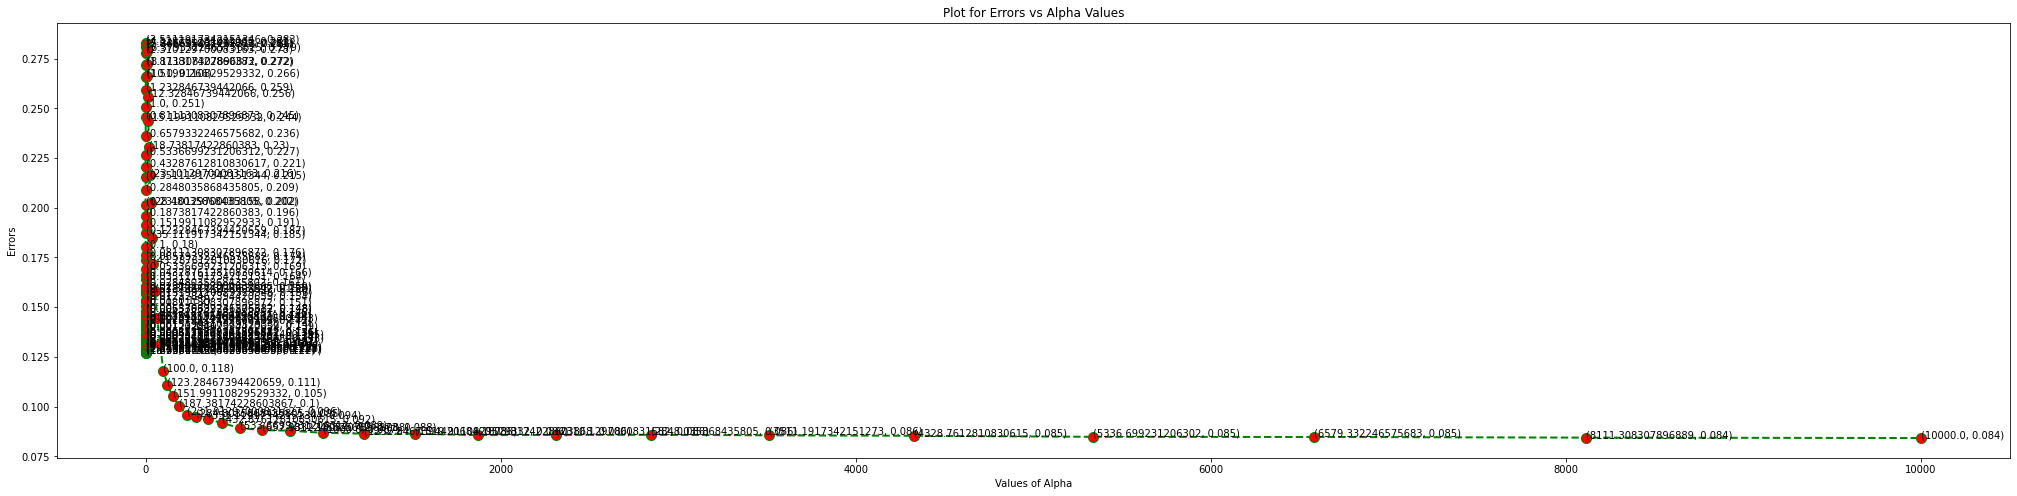

The top 50 most frequent words from the positive class are :

['great' 'love' 'good' 'like' 'tast' 'not' 'use' 'tri' 'flavor' 'one'
 'product' 'make' 'get' 'best' 'time' 'would' 'buy' 'also' 'find' 'realli'
 'price' 'much' 'well' 'littl' 'store' 'recommend' 'coffe' 'perfect'
 'better' 'delici' 'order' 'year' 'found' 'eat' 'work' 'enjoy' 'favorit'
 'need' 'day' 'way' 'even' 'look' 'high' 'amazon' 'give' 'nice' 'want'
 'bought' 'purchas' 'first']

The top 50 most frequent words from the negative class are :

['not' 'disappoint' 'tast' 'product' 'like' 'wast' 'would' 'buy' 'money'
 'return' 'one' 'order' 'away' 'bad' 'receiv' 'thought' 'stale' 'aw'
 'threw' 'review' 'tri' 'box' 'packag' 'could' 'look' 'even' 'howev'
 'mayb' 'want' 'realli' 'bought' 'amazon' 'open' 'pictur' 'throw'
 'purchas' 'trash' 'much' 'brand' 'know' 'item' 'sorri' 'get' 'flavor'
 'good' 'refund' 'price' 'stuck' 'never' 'terribl']

'''PERFORMANCE EVALUATION'''


Detailed report for the Bag-of-Words Vectorization.

The

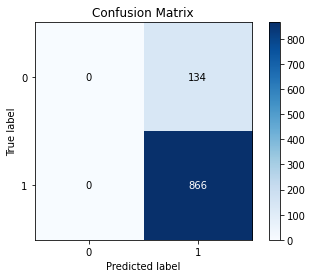

In [48]:
'''Creating the Bag of Words vector for the cleaned reviews.'''
#Bag of Words model creation using cleaned text 

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText'][0:5000]
y = sampled_dataset['Class_Labels'][0:5000]
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the BOW constructor
cv_object = CountVectorizer().fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations. 
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bag-of-Words", cv_object)

<b>Naive Bayes on the TF-IDF model created using 'CleanedText' texts.</b>


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (4000, 7960)
The shape of the X_test_vectors is : (1000, 7960)
Starting Cross Validation steps...

GridSearchCV completed for TF-IDF model!
Best estimator for TF-IDF model :  MultinomialNB(alpha=10000.0)
Best Score for TF-IDF model :  0.915388294918959
The optimal value of alpha is : 10000.0


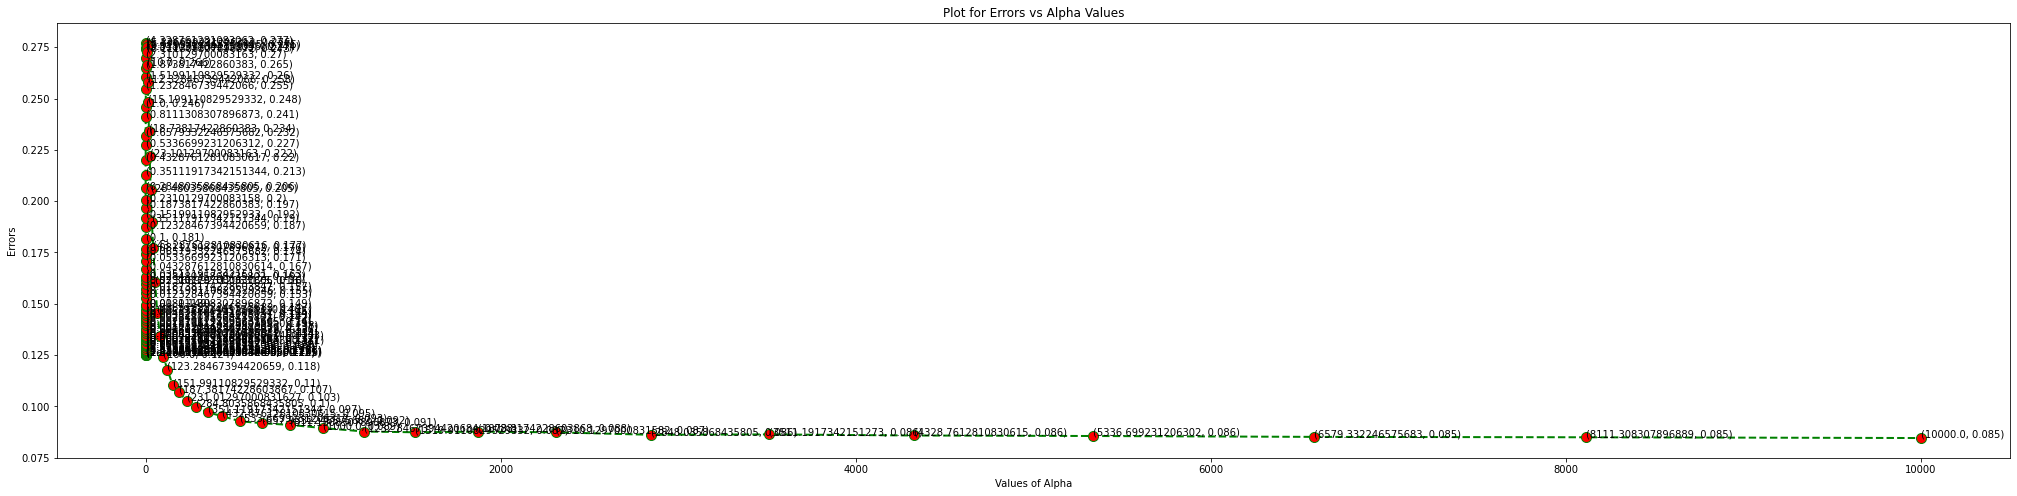

The top 50 most frequent words from the positive class are :

['great' 'love' 'like' 'good' 'tast' 'not' 'flavor' 'use' 'product' 'tri'
 'make' 'one' 'get' 'time' 'best' 'would' 'coffe' 'price' 'also' 'buy'
 'well' 'find' 'realli' 'much' 'littl' 'store' 'eat' 'order' 'amazon'
 'recommend' 'food' 'year' 'better' 'delici' 'day' 'perfect' 'cup' 'give'
 'favorit' 'need' 'work' 'found' 'high' 'look' 'tea' 'enjoy' 'even' 'way'
 'drink' 'purchas']

The top 50 most frequent words from the negative class are :

['not' 'disappoint' 'tast' 'like' 'wast' 'product' 'would' 'one' 'return'
 'money' 'thought' 'away' 'buy' 'bad' 'aw' 'order' 'box' 'stale' 'review'
 'receiv' 'packag' 'mayb' 'look' 'tri' 'could' 'even' 'threw' 'open'
 'howev' 'bag' 'flavor' 'throw' 'pictur' 'trash' 'amazon' 'descript'
 'terribl' 'refund' 'much' 'stuck' 'want' 'realli' 'get' 'worst' 'horribl'
 'brand' 'know' 'anoth' 'item' 'sorri']

'''PERFORMANCE EVALUATION'''


Detailed report for the TF-IDF Vectorization.

The number o

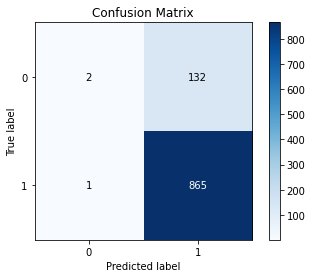

In [50]:
'''TF-IDF model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText'][0:5000]
y = sampled_dataset['Class_Labels'][0:5000]
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = tf_idf_object.transform(X_train)
X_test_vectors = tf_idf_object.transform(X_test)

#Colum Standardization of the TF-IDF vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF", tf_idf_object)

<b>Naive Bayes on the Bigrams model created using 'PreserveStopwords':</b>


Creating the BOW vectors using PreserveStopwords corpus
The shape of the X_train_vectors is : (4000, 120431)
The shape of the X_test_vectors is : (1000, 120431)
Starting Cross Validation steps...

GridSearchCV completed for Bi-Grams model!
Best estimator for Bi-Grams model :  MultinomialNB(alpha=10000.0)
Best Score for Bi-Grams model :  0.8964212708931918
The optimal value of alpha is : 10000.0


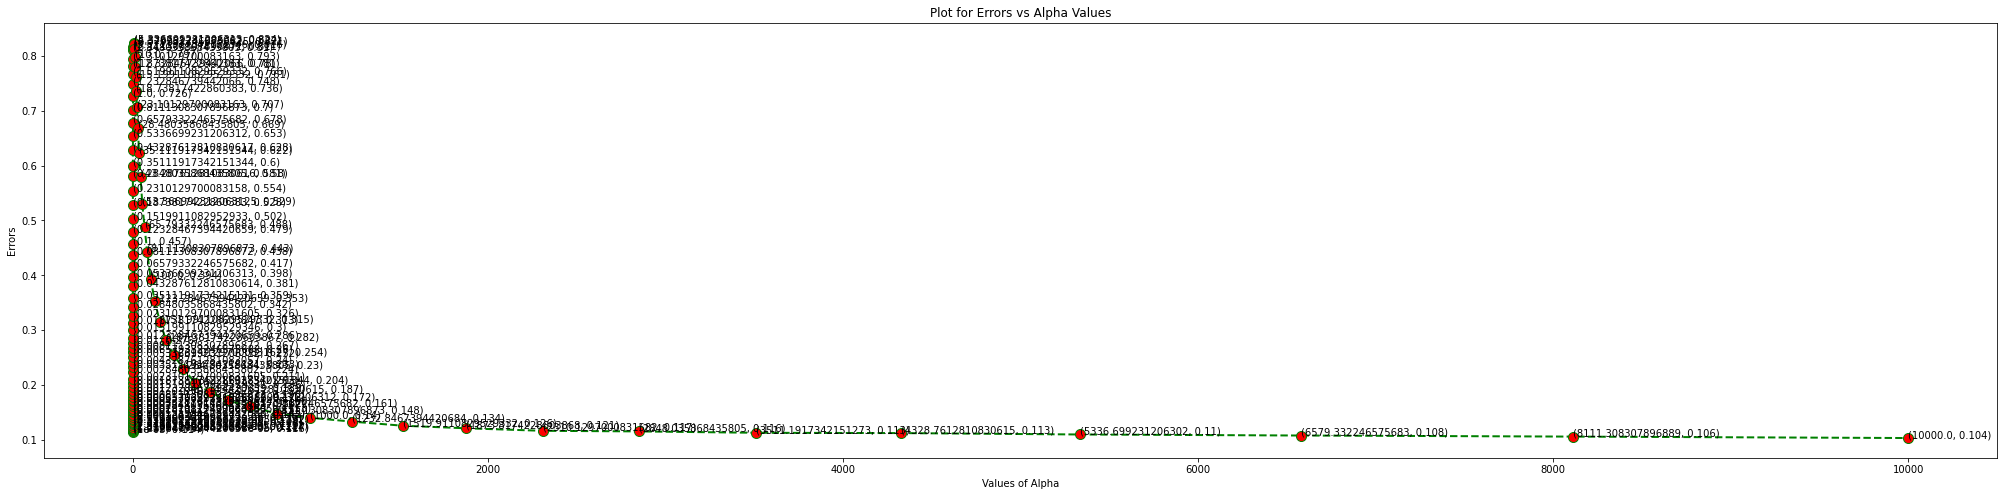

The top 50 most frequent words from the positive class are :

['and' 'the' 'to' 'this' 'is' 'it' 'of' 'for' 'in' 'my' 'have' 'with'
 'that' 'but' 'on' 'so' 'great' 'you' 'are' 'good' 'like' 'as' 'not'
 'they' 'was' 'these' 'at' 'love' 'just' 'can' 'very' 'or' 'all' 'them'
 'this is' 'be' 'if' 'one' 'flavor' 'product' 'when' 'taste' 'it is'
 'more' 'has' 'will' 'from' 'in the' 'of the' 'best']

The top 50 most frequent words from the negative class are :

['the' 'not' 'and' 'this' 'of' 'to' 'it' 'was' 'but' 'in' 'that' 'is' 'be'
 'for' 'from' 'disappointed' 'like' 'if' 'had' 'my' 'have' 'waste' 'all'
 'on' 'product' 'were' 'they' 'it was' 'taste' 'would' 'with' 'of the'
 'at' 'money' 'no' 'you' 'one' 'at all' 'thought' 'so' 'as' 'away'
 'because' 'will' 'very disappointed' 'in the' 'out' 'did' 'there' 'bad']

'''PERFORMANCE EVALUATION'''


Detailed report for the Bi-Grams Vectorization.

The number of accurate predictions out of 1000 data points on unseen data is 868
Accuracy of the Bi-

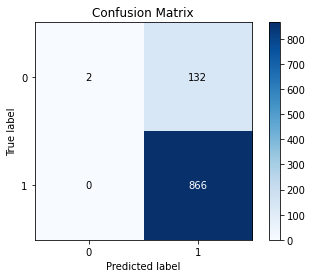

In [51]:
'''Bi Grams model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords'][0:5000]
y = sampled_dataset['Class_Labels'][0:5000]
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
bigrams_object = TfidfVectorizer(ngram_range=(1,2)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using PreserveStopwords corpus")
X_train_vectors = bigrams_object.transform(X_train)
X_test_vectors = bigrams_object.transform(X_test)

#Colum Standardization of the T-gram vector created using preserved stopwords data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bi-Grams", bigrams_object)

<b>Naive Bayes on the Tri-grams model created using 'PreserveStopwords':</b>


Creating the BOW vectors using PreserveStopwords corpus
The shape of the X_train_vectors is : (4000, 311903)
The shape of the X_test_vectors is : (1000, 311903)
Starting Cross Validation steps...

GridSearchCV completed for Tri-Grams model!
Best estimator for Tri-Grams model :  MultinomialNB(alpha=1e-05)
Best Score for Tri-Grams model :  0.6832449815823525
The optimal value of alpha is : 1e-05


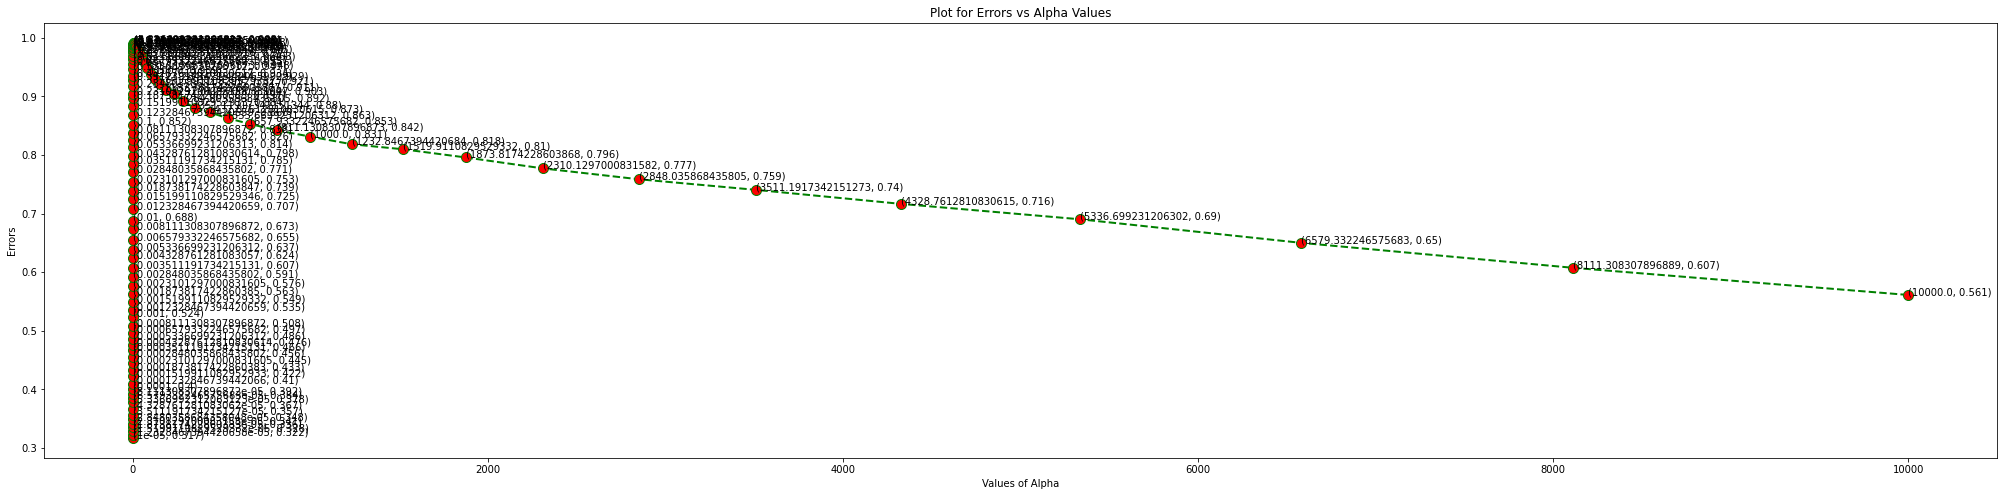

The top 50 most frequent words from the positive class are :

['this is' 'it is' 'in the' 'of the' 'the best' 'if you' 'and the'
 'this product' 'and it' 'is the' 'they are' 'on the' 'for the' 'with the'
 'in my' 'to the' 'for my' 'to be' 'you can' 'is great' 'and they'
 'it was' 'these are' 'to find' 'the price' 'have to' 'one of' 'to get'
 'to make' 'all the' 'it in' 'like the' 'love this' 'love it' 'have been'
 'but it' 'this is the' 'and have' 'at the' 'is very' 'of my' 'of this'
 'it has' 'and this' 'the flavor' 'lot of' 'to have' 'it and'
 'my favorite' 'love the']

The top 50 most frequent words from the negative class are :

['it was' 'of the' 'at all' 'in the' 'very disappointed' 'will not'
 'to be' 'did not' 'on the' 'not buy' 'to the' 'not the' 'this product'
 'is not' 'would not' 'waste of' 'not recommend' 'the same' 'was not'
 'the product' 'your money' 'waste of money' 'do not' 'if you'
 'waste your money' 'of money' 'but the' 'disappointed with' 'not worth'
 'waste your'

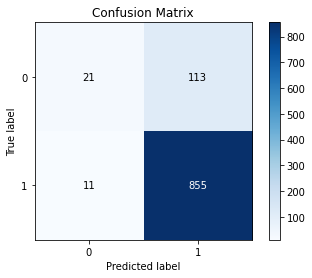

In [52]:
'''Tri-Grams model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.
This model won't contain single words. This will mostly try to figure out the relationships between consecutive words in a sentences '''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords'][0:5000]
y = sampled_dataset['Class_Labels'][0:5000]
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tri_grams_object = TfidfVectorizer(ngram_range=(2,3)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using PreserveStopwords corpus")
X_train_vectors = tri_grams_object.transform(X_train)
X_test_vectors = tri_grams_object.transform(X_test)

#Colum Standardization of the tri-gram vector created using preserved stopwords data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Tri-Grams", tri_grams_object)

<b>Conclusion :</b><br>
From the below comparison chart we can see get an idea aboout how the different vectorizers perform.

In [53]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", " Hyper-Parameter Value (alpha=)", "Train Error", "Test Error", "F1-Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_NB.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
|    Model     |  Hyper-Parameter Value (alpha=) | Train Error | Test Error | F1-Score | No. Of accurate predictions |
+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
| Bag-of-Words |             10000.0             |    0.1587   |   0.134    |  0.9282  |             866             |
|    TF-IDF    |             10000.0             |    0.1584   |   0.133    |  0.9286  |             867             |
|   Bi-Grams   |             10000.0             |    0.3569   |   0.132    |  0.9292  |             868             |
|  Tri-Grams   |              1e-05              |    0.7401   |   0.124    |  0.9324  |             876             |
+--------------+---------------------------------+-------------+------------+----------+------------